In [1]:
import pandas as pd
import numpy as np
import numpy as np
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import *
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots    
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

## Import and Prepare Data 

In [3]:
df_2013 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2013.csv')
df_2014 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2014.csv')
df_2015 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2015.csv')
df_2016 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2016.csv')
df_2017 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2017.csv')
df_2018 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2018.csv')
df_2019 = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_2019.csv')

In [4]:
def prep_V5(df):
    #df['24-hour-SMA'] = df['load_MW'].rolling(window=24).mean()
    #df['24-hour-Std-temp'] = df['temperature'].rolling(window=24).std()
    #df['24-hour-Std'] = df['load_MW'].rolling(window=24).std()
    df['load (t-24)'] = df.load_MW.shift(24) 
    df['first seasonal difference'] = df.load_MW.shift(24) - df.load_MW.shift(25) 
    df['prev-day-hour-Std'] = df.load_MW.shift(24).rolling(window=24).std()
    df['prev-day-hour-MA'] = df.load_MW.shift(24).rolling(window=24).mean()
    #df['temp (t-24)'] = df.temperature.shift(24) 
    df = df.dropna(axis = 0, how ='any')
    return df 

In [5]:
df_2014 = prep_V5(df_2014)
df_2015 = prep_V5(df_2015)
df_2016 = prep_V5(df_2016)
df_2017 = prep_V5(df_2017)
df_2018 = prep_V5(df_2018)
df_2019 = prep_V5(df_2019)

In [6]:
total = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019]

In [7]:
master_df = pd.concat(total)

In [8]:
master_df = master_df.set_index('timestamp')

In [9]:
master_df[master_df['temperature'] == 0] = np.NaN
master_df[master_df['humidity'] == 0] = np.NaN
master_df = master_df.fillna(method='ffill')

In [10]:
model_df = master_df.copy()
day_dummies = pd.get_dummies(model_df['day_of_week'], prefix='day', drop_first=True)
hour_dummies = pd.get_dummies(model_df['hour_of_day'], prefix='hour', drop_first=True)
holiday_dummies = pd.get_dummies(model_df['holiday'], prefix='holiday', drop_first=True)
model_df = model_df.drop(['day_of_week', 'hour_of_day', 'holiday'], axis=1)
model_df = pd.concat([model_df, day_dummies, hour_dummies, holiday_dummies], axis=1)

In [11]:
 model_df = model_df.dropna(axis = 0, how ='any')

In [12]:
model_df = model_df.to_csv('training.csv')

In [12]:
model_df['temperature'] = (model_df['temperature'] - np.mean(model_df['temperature'])) / np.sqrt(np.var(model_df['temperature']))
model_df['load (t-24)'] = (model_df['load (t-24)'] - np.mean(model_df['load (t-24)'])) / np.sqrt(np.var(model_df['load (t-24)']))
model_df['first seasonal difference'] = (model_df['first seasonal difference'] - np.mean(model_df['first seasonal difference'])) / np.sqrt(np.var(model_df['first seasonal difference']))
model_df['prev-day-hour-Std'] = (model_df['prev-day-hour-Std'] - np.mean(model_df['prev-day-hour-Std'])) / np.sqrt(np.var(model_df['prev-day-hour-Std']))
model_df['prev-day-hour-MA'] = (model_df['prev-day-hour-MA'] - np.mean(model_df['prev-day-hour-MA'])) / np.sqrt(np.var(model_df['prev-day-hour-MA']))




Train test split 

In [13]:
train = model_df['2013-06-15 22:00:00-04:00':'2018-09-14 23:00:00-04:00']
test = model_df['2019-06-15 22:00:00-04:00':'2019-09-14 23:00:00-04:00']

In [14]:
X_train = train.drop('load_MW', axis=1)
X_test = test.drop('load_MW', axis=1)
y_train = train['load_MW']
y_test = test['load_MW']

In [17]:
X_train.columns

Index(['cloudcover', 'first seasonal difference', 'humidity', 'load (t-24)',
       'prev-day-hour-MA', 'prev-day-hour-Std', 'temperature', 'uvindex',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'hour_1.0', 'hour_2.0', 'hour_3.0',
       'hour_4.0', 'hour_5.0', 'hour_6.0', 'hour_7.0', 'hour_8.0', 'hour_9.0',
       'hour_10.0', 'hour_11.0', 'hour_12.0', 'hour_13.0', 'hour_14.0',
       'hour_15.0', 'hour_16.0', 'hour_17.0', 'hour_18.0', 'hour_19.0',
       'hour_20.0', 'hour_21.0', 'hour_22.0', 'hour_23.0', 'holiday_1.0'],
      dtype='object')

Run XG Boost

In [15]:
import xgboost as xgb

In [16]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)
training_preds = reg.predict(X_train)
val_preds = reg.predict(X_test)

[08:48:57] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Save model as pickle file 

In [20]:
import pickle
# Save
file_name = 'xg_boost_load_model.pkl'
pickle.dump(reg, open(file_name, "wb")) 

In [17]:
print('Mean Absolute Error:', mean_absolute_error(y_test, val_preds))  
print('Mean Squared Error:', mean_squared_error(y_test, val_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, val_preds)))

Mean Absolute Error: 709.9192871545443
Mean Squared Error: 801278.9594429482
Root Mean Squared Error: 895.1418655402887


In [18]:
df_pred = pd.DataFrame(val_preds)
df_test = pd.DataFrame(y_test)
df_test = df_test.reset_index()
df_lets_see = df_test.join(df_pred)
df_lets_see = df_lets_see.set_index('timestamp')
df_lets_see.columns = ['actual load (MW)', 'predicted load (MW)']

In [30]:
X_train.head()

,cloudcover,first seasonal difference,humidity,load (t-24),prev-day-hour-MA,prev-day-hour-Std,temperature,uvindex,day_Monday,day_Saturday,...,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,holiday_1.0
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-06-16 22:00:00-04:00,0.15,-0.780494,0.69,-0.807913,-2.069405,-1.250534,-0.689367,0.0,1,0,...,0,0,0,0,0,0,0,1,0,0
2014-06-16 23:00:00-04:00,0.19,-1.537756,0.71,-1.147535,-2.035118,-1.276248,-0.779867,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
2014-06-17 00:00:00-04:00,0.23,-1.564600,0.74,-1.493079,-2.021879,-1.305241,-0.819460,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-17 01:00:00-04:00,0.71,-0.970813,0.76,-1.707615,-2.008962,-1.354490,-0.849155,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-17 02:00:00-04:00,0.32,-0.514230,0.77,-1.821412,-1.994584,-1.424485,-0.898647,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text xticklabel objects>)

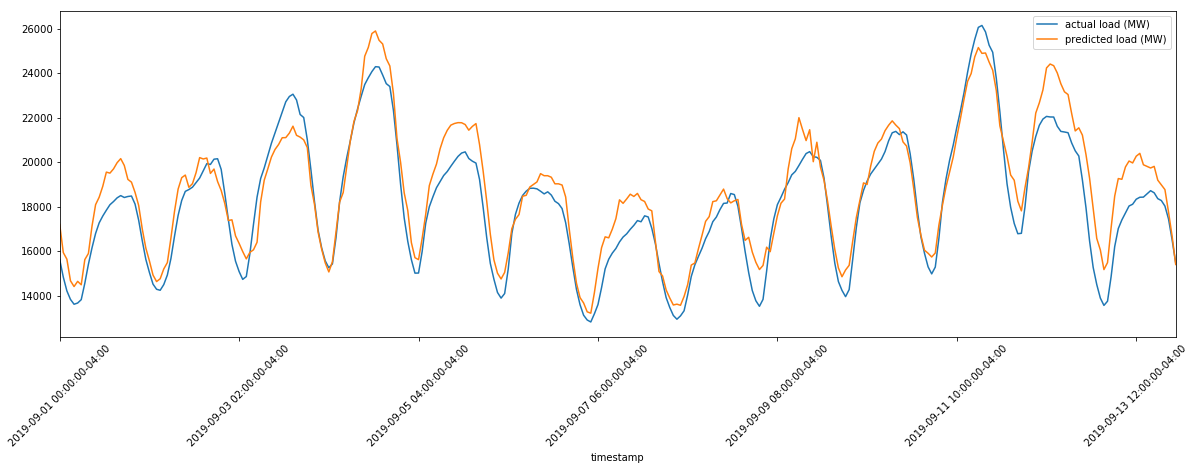

In [20]:
df_lets_see['2019-09-01' : '2019-09-14'].plot(figsize=(20,6))
plt.xticks(rotation=45)

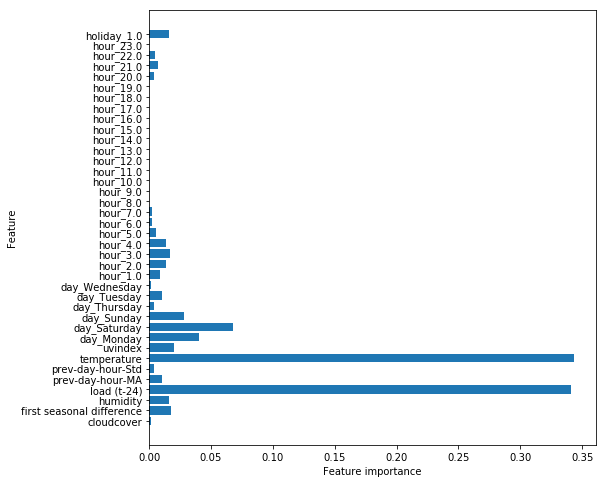

In [21]:
plot_feature_importances(reg)

Compare to NYISO official forecast 

In [22]:
df_nyiso = pd.read_csv('/Users/kylebaranko/Final_Project/csvs/nyiso_load_forecast_sept.csv')
df_nyiso.columns = [['timestamp', 'NYISO Predicted Load']]

In [23]:
df_nyiso.columns = df_nyiso.columns.get_level_values(0)

In [24]:
df_nyiso['timestamp'] = pd.to_datetime(df_nyiso['timestamp'], format='%Y-%m-%d %H:%M')

In [25]:
df_nyiso = df_nyiso.set_index('timestamp')
df_nyiso = df_nyiso.tz_localize('US/Eastern')
df_lets_see = df_lets_see.reset_index()
df_lets_see['timestamp'] = pd.to_datetime(df_lets_see['timestamp'], format='%Y-%m-%d %H:%M')
df_lets_see = df_lets_see.set_index('timestamp')

In [26]:
df_lets_see = df_lets_see['2019-09-01' : '2019-09-14']

In [27]:
df_lets_see = df_lets_see.reset_index()
df_nyiso = df_nyiso['2019-09-01' : '2019-09-14']
df_nyiso = df_nyiso.reset_index()
df_lets_see = df_lets_see.merge(df_nyiso, how='inner', on='timestamp')
df_lets_see = df_lets_see.set_index('timestamp')


(array([737303.16666667, 737305.16666667, 737307.16666667, 737309.16666667,
        737311.16666667, 737313.16666667, 737315.16666667]),
 <a list of 7 Text xticklabel objects>)

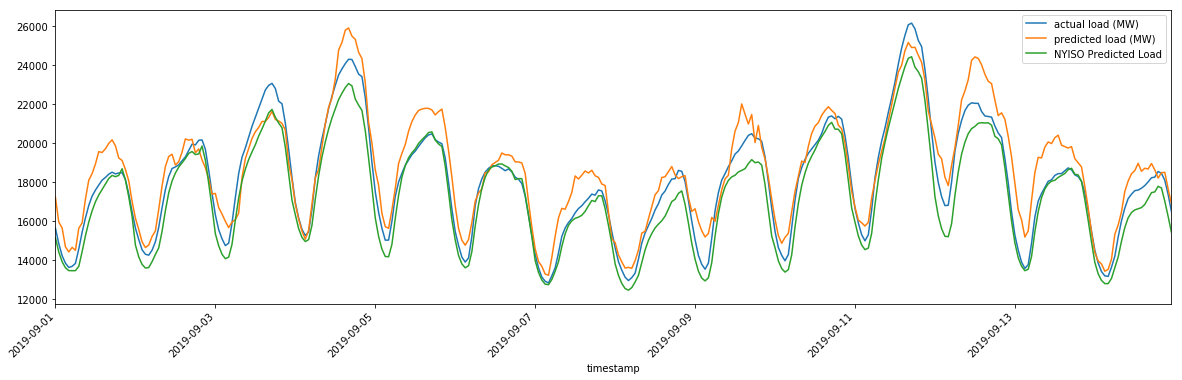

In [28]:
df_lets_see.plot(figsize=(20,6))
plt.xticks(rotation=45)

In [68]:
nyiso_test = y_test['2019-09-01' : '2019-09-14']
nyiso_predictions = df_lets_see['NYISO Predicted Load']
nyiso_predictions = nyiso_predictions['2019-09-01' : '2019-09-13']
print('Mean Absolute Error:', mean_absolute_error(nyiso_test, nyiso_predictions))  
print('Mean Squared Error:', mean_squared_error(nyiso_test, nyiso_predictions))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(nyiso_test, nyiso_predictions)))

Mean Absolute Error: 746.2660256410256
Mean Squared Error: 811891.1526282053
Root Mean Squared Error: 901.0500278165498
